## Preamble

+ Run these lines of code first to import the necessary libraries and set up the plotting environment.

In [ ]:
## Preamble / required packages
import numpy as np
import scipy
np.random.seed(0)

## Import local plotting functions and in-notebook display functions

import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')

# Autoreload
%load_ext autoreload
%autoreload 2


# Word embeddings

Using NLTK, import a text file, tokenize it, and train a Word2Vec model.

In [ ]:
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec, KeyedVectors

# Ensure you have the necessary tokenizer models
nltk.download('punkt')

# Read and preprocess text from the file
with open('./data/frankenstein.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Convert chapters
def int_to_roman(num):
    roman_numerals = [
        (1000, "M"),
        (900,  "CM"),
        (500,  "D"),
        (400,  "CD"),
        (100,  "C"),
        (90,   "XC"),
        (50,   "L"),
        (40,   "XL"),
        (10,   "X"),
        (9,    "IX"),
        (5,    "V"),
        (4,    "IV"),
        (1,    "I")
    ]
    roman = ""
    for value, numeral in roman_numerals:
        count, num = divmod(num, value)
        roman += numeral * count
    return roman
text.split('\nI\n')[1]
roman_numerals = [int_to_roman(i) for i in range(1, 24)]
roman_numerals = [f'\n{item}\n' for item in roman_numerals]
text_chapters = [text.split(item)[1] for item in roman_numerals]

# Tokenize the text into sentences and words
sentences = nltk.sent_tokenize(text)
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# === Option 1: Train a custom Word2Vec model ===
custom_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,     # dimensionality of the feature vectors
    window=5,            # maximum distance between current and predicted word within a sentence
    min_count=1,         # ignores all words with total frequency lower than this
    workers=4            # number of worker threads to use
)
custom_model.save("word2vec_custom.model")

# === Option 2: Load a pre-trained Word2Vec model ===
# Example: Loading Google's pre-trained model (requires the binary file)
pretrained_model = KeyedVectors.load_word2vec_format(
    'private_data/GoogleNews-vectors-negative300.bin', 
    binary=True
)


In [ ]:
import nltk
nltk.download('punkt')

with open('./data/frankenstein.txt', 'r', encoding='utf-8') as f:
    text = f.read()

tokens = nltk.word_tokenize(text)
word_list_ordered = nltk.word_tokenize(text)
unique_tokens = list(dict.fromkeys(word_list_ordered))

# For a KeyedVectors object, access vectors directly without .wv
embeddings = {word: pretrained_model[word] for word in unique_tokens if word in pretrained_model}
embedded_words = list(embeddings.keys())
# Extract embeddings for each word using the custom model's vocabulary
# embeddings = {word: custom_model.wv[word] for word in unique_tokens if word in custom_model.wv}


# print(embeddings.get("boy"))

print(embeddings["boy"].shape)

[nltk_data] Downloading package punkt to /Users/william/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(300,)


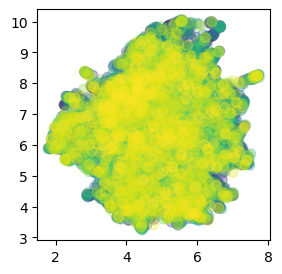

In [4]:
# get embedding matrix and keys
all_tokens = list()
all_embeddings = list()
for key in embeddings.keys():
    all_tokens.append(key)
    all_embeddings.append(embeddings[key])
all_embeddings = np.array(all_embeddings)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from umap import UMAP


# embedder = Pipeline([('pca', PCA(n_components=50)), ('umap', UMAP(n_components=2))])
embedder = UMAP(n_components=2, n_neighbors=50, random_state=0)
# embedder = PCA(n_components=2, random_state=0)
Xumap = embedder.fit_transform(all_embeddings)

plt.figure(figsize=(3, 3))
plt.scatter(Xumap[:, 0], Xumap[:, 1], alpha=0.3, marker='.', s=200, c=np.arange(len(all_tokens)))

In [ ]:
## Split chapters

all_embedding_chapters = []
all_tokens_chapters = []
for i, text in enumerate(text_chapters):
    print(i)

    tokens = nltk.word_tokenize(text)
    word_list_ordered = nltk.word_tokenize(text)
    unique_tokens = list(dict.fromkeys(word_list_ordered))

    # For a KeyedVectors object, access vectors directly without .wv
    embeddings_i = {word: pretrained_model[word] for word in unique_tokens if word in pretrained_model}
    embedded_words_i = list(embeddings.keys())
    # Extract embeddings for each word using the custom model's vocabulary
    # embeddings = {word: custom_model.wv[word] for word in unique_tokens if word in custom_model.wv}

    # get embedding matrix and keys
    all_tokens = list()
    all_embeddings_i = list()
    for key in embeddings_i.keys():
        all_tokens.append(key)
        all_embeddings_i.append(embeddings_i[key])
    all_embeddings_i = np.array(all_embeddings_i)

    all_embedding_chapters.append(all_embeddings_i.copy())
    all_tokens_chapters.append(all_tokens.copy())



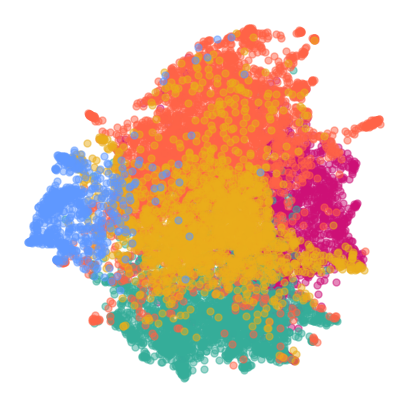

In [6]:
import degas as dg
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

X = all_embeddings.copy()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=50)  # adjust n_components to retain sufficient variance
X_reduced = pca.fit_transform(X_scaled)

# clusterer = HDBSCAN(min_cluster_size=50, min_samples=1, cluster_selection_epsilon=0.5)
# clusterer.fit(X_reduced)

clusterer = KMeans(n_clusters=5, random_state=0)
clusterer.fit(X_reduced)

colors = [dg.magenta, dg.turquoise,  dg.red, dg.orange, dg.blue]
# Journey, Nature, Violence, Cities, People

plt.figure(figsize=(5, 5))
tokens_themes = []
for i, cluster in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == cluster
    plt.scatter(Xumap[mask, 0], Xumap[mask, 1], alpha=0.5, marker='.', s=100, c=colors[i])
    ## get tokens in cluster
    tokens = np.array(all_tokens)[mask]
    tokens_themes.append(tokens.copy())
    
dg.vanish_axes()
# plt.scatter(Xumap[:, 0], Xumap[:, 1], alpha=0.8, marker='.', s=100, c=clusterer.labels_)
# plt.colorbar()

# dg.better_savefig(
#     "/Users/william/program_repos/dygene/writing/fig_resources/word2vec_clusters.pdf", 
#     dpi=300, transparent=True
# )

In [494]:

for i in range(5):
    dd = " ".join(tokens_themes[i])
    # save to file
    with open(f"cluster_{i}.txt", "w") as f:
        f.write(dd)

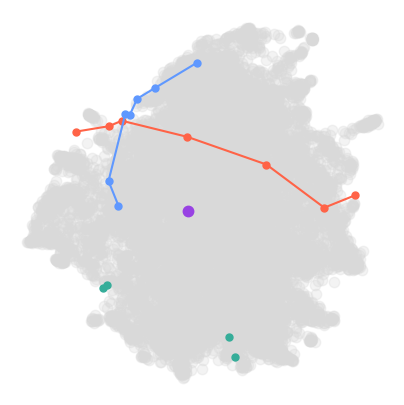

In [ ]:



import degas as dg

plt.figure(figsize=(5, 5))
plt.plot(Xumap[:, 0], Xumap[:, 1], '.', markersize=15, color=np.ones(3) * 0.85, alpha=0.3)

test_words = ["warm","freezing", "mild", "lukewarm",  "cool", "hot", "scorching"]
test_embeddings = [pretrained_model[word] for word in test_words if word in pretrained_model]
test_embeddings = np.array(test_embeddings)
Xumap_test = embedder.transform(test_embeddings)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '.', color=dg.red, markersize=10)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '-', color=dg.red)


test_words = [ "excited", "ecstatic",  "relaxed", "content", "calm", "peaceful","energetic"]
test_embeddings = [pretrained_model[word] for word in test_words if word in pretrained_model]
test_embeddings = np.array(test_embeddings)
Xumap_test = embedder.transform(test_embeddings)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '.', color=dg.blue, markersize=10)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '-', color=dg.blue)


test_words = ["mad"]
test_embeddings = [pretrained_model[word] for word in test_words if word in pretrained_model]
test_embeddings = np.array(test_embeddings)
Xumap_test = embedder.transform(test_embeddings)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '.', color=dg.purple, markersize=15)


# test_words = ["bird", "cage"]
# test_words = ["bird", "cage"]
# test_words = ["ice", "bucket"]
# test_words = ["whiskey", "flask"]
test_words = ["wine", "glass"]
# test_words = ["cider", "jug"]
test_embeddings = [pretrained_model[word] for word in test_words if word in pretrained_model]
test_embeddings = np.array(test_embeddings)
Xumap_test = embedder.transform(test_embeddings)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '.', color=dg.turquoise, markersize=10)

test_words = ["whiskey", "flask"]
# test_words = ["brandy", "cask"]
# test_words = ["dog", "kennel"]
test_embeddings = [pretrained_model[word] for word in test_words if word in pretrained_model]
test_embeddings = np.array(test_embeddings)
Xumap_test = embedder.transform(test_embeddings)
plt.plot(Xumap_test[:, 0], Xumap_test[:, 1], '.', color=dg.turquoise, markersize=10)

dg.fixed_aspect_ratio(1)
dg.vanish_axes()

# dg.better_savefig(
#     "/Users/william/program_repos/dygene/writing/fig_resources/word2vec_analogies.pdf", 
#     dpi=300, transparent=True
# )

# Visualize gene expression in PBMCs

In [2]:
import scanpy as sc
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
# scv.settings.presenter_view = True  # set max width size for presenter view
# scv.set_figure_params('scvelo')  # for beautified visualization

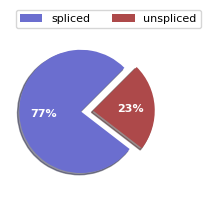

In [3]:
# adata = scv.datasets.pancreas()
adata = scv.datasets.pbmc68k()
scv.pl.proportions(adata)


In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
scv.pp.log1p(adata)

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

## Run UMAP
sc.tl.umap(adata)
## adata.obsm['X_umap'] = embedder.transform(adata.X)


Filtered out 33338 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Filtered out 28 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_71108/1062382244.py:4: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)
/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/var/folders/79/zct6q7kx2yl6b1ryp2rsfbtc0000gr/T/ipykernel_71108/1062382244.py:7: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be remo

computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
## Estimate RNA velocity
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)



computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/65877 [00:00<?, ?cells/s]

    finished (0:00:26) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:15) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [7]:
adata.uns['iroot'] = np.argmin(adata.obs["velocity_pseudotime"])
sc.tl.dpt(adata)

/Users/william/mamba/envs/word/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3549: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


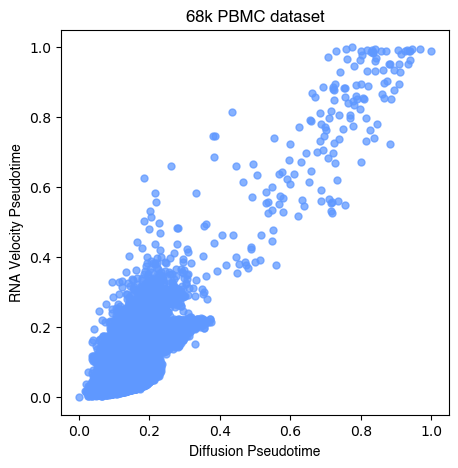

In [ ]:
# ## Run velocity pseudo-time and dpt
scv.tl.velocity_pseudotime(adata)
adata.uns['iroot'] = np.argmin(adata.obs["velocity_pseudotime"])
sc.tl.dpt(adata)

## Confirm ordering of cells is the same across fields
np.alltrue(
    adata.obs["dpt_pseudotime"].index == adata.obs["velocity_pseudotime"].index
)


import degas as dg
plt.figure(figsize=(5, 5))
plt.plot(adata.obs["dpt_pseudotime"], adata.obs["velocity_pseudotime"], 
         '.', 
         color=dg.blue,
         alpha=0.75, markersize=10)
plt.xlabel("Diffusion Pseudotime", fontname="Helvetica")
plt.ylabel("RNA Velocity Pseudotime", fontname="Helvetica")
plt.title("68k PBMC dataset", fontname="Helvetica")


dg.better_savefig(
    "pseudotime_comparison_pbmc68k.pdf", 
    dpi=300, transparent=True
)


/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/william/mamba/envs/word/lib/python3.12/site-packages/scvelo/plo

saving figure to file /Users/william/program_repos/dygene/writing/fig_resources/immune_clusters.pdf


<Figure size 500x500 with 0 Axes>

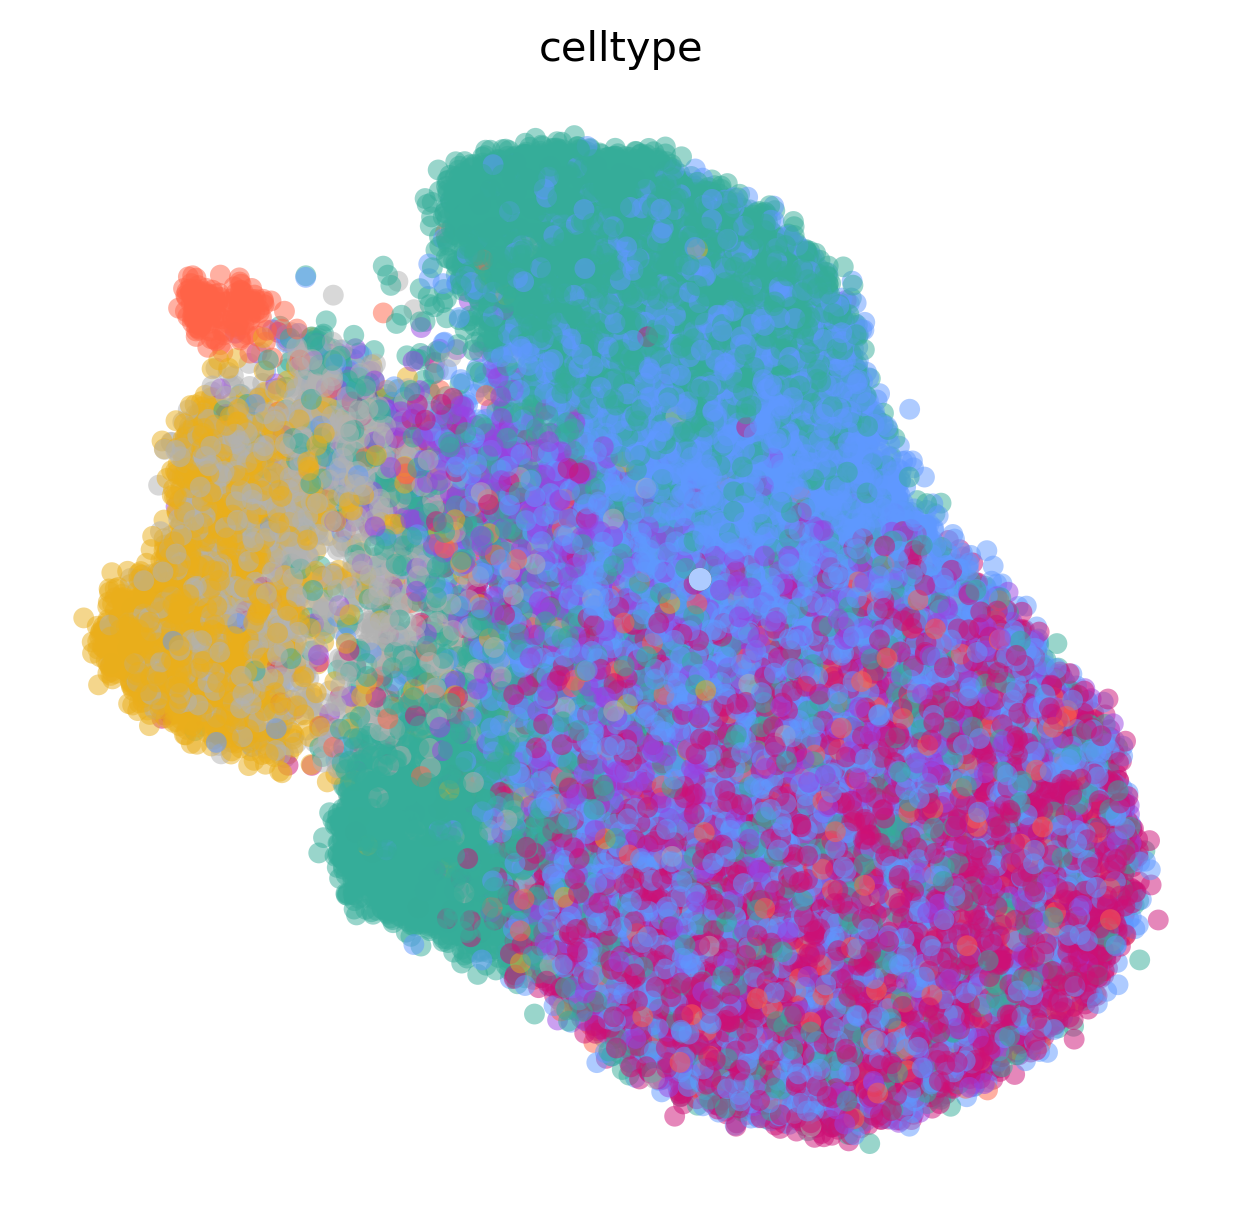

In [12]:

cluster_key = "celltype"
colors = [dg.magenta, dg.purple,  dg.red, dg.turquoise, dg.blue, dg.magenta, 
          dg.orange, dg.turquoise, dg.red, dg.turquoise, dg.gray, dg.gray, dg.gray]

outpath = "/Users/william/program_repos/dygene/writing/fig_resources/immune_clusters.pdf"
plt.figure(figsize=(5, 5))
# scv.pl.scatter(adata, 
#                basis='umap', s=100, alpha=0.5, add_outline=False, outline_width=(0,0),
#                save=outpath
# )
scv.pl.scatter(adata, 
               basis='umap', 
               color=cluster_key,
               palette=colors,
               s=100, alpha=0.5, 
               add_outline=False, outline_width=(0,0),
               aspect=0.85,
               dpi=300,
               save=outpath
)
# dg.better_savefig(outpath, dpi=300, transparent=True)


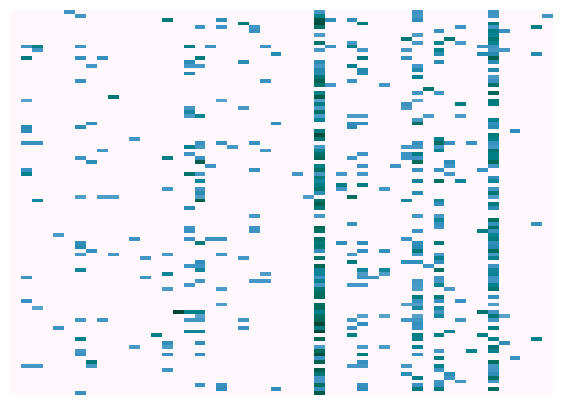

In [659]:
plt.figure(figsize=(7, 5))
plt.imshow(adata.X[:100, :50].toarray(), cmap='PuBuGn', aspect='auto')
dg.vanish_axes()

dg.better_savefig(
    "/Users/william/program_repos/dygene/writing/fig_resources/immune_expression_counts.pdf", 
    dpi=300, transparent=True
)
